In [9]:
### Essential libraries.

import numpy as np

import pandas as pd


from hazm import *

import re

import ast


from gensim.models import Word2Vec


from sklearn import preprocessing

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import KernelPCA

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

from sklearn import metrics


import matplotlib.pyplot as plt

In [2]:
### Hyperparameters.

FLAGS = {
"pca_n_component": 64,
"w2v_size": 64,
"w2v_window": 5,
"w2v_min_count": 2,
"max_n_center": 30
}

data_path = "./Raw_Data/hamshahri.json"
preprocessing_path = "./Data"
result_path = "./Results/"

In [3]:
### Reading and Cleaning data.

data = pd.read_json(data_path, encoding='utf-8')

data['major_label'], data['minor_label'] = zip(*data['tags'].map(lambda x: x[0].split('>')))

le = preprocessing.LabelEncoder()
le.fit(data['major_label'])
data['major_label_number'] = le.transform(data['major_label'])

In [4]:
### Exploration.

data.head(5)

,link,summary,tags,title,major_label,minor_label,major_label_number
0,https://www.hamshahrionline.ir/news/503910/پرت...,رئیس مرکز اطلاعات و کنترل ترافیک پلیس راهور نا...,[اجتماع > سفر],پرترافیک‌ترین جاده‌های ایران پس از پایان ممنوع...,اجتماع,سفر,0
1,https://www.hamshahrionline.ir/news/503441/نخس...,معاون حج و عمره سازمان حج و زیارت اعلام کرد: د...,[اجتماع > سفر],نخستین کاروان حج ۹۹ ششم تیر اعزام می‌شود,اجتماع,سفر,0
2,https://www.hamshahrionline.ir/news/503002/ممن...,رییس مرکز اطلاعات و کنترل ترافیک پلیس راهور نا...,[اجتماع > سفر],ممنوعیت ترددهای بین استانی لغو شد,اجتماع,سفر,0
3,https://www.hamshahrionline.ir/news/502442/نکا...,ممکن است با شروع فعالیت کسب‌وکارها برخی مجبور ...,[اجتماع > سفر],نکات ضدکرونایی که باید در سفرهای ضروری رعایت کنید,اجتماع,سفر,0
4,https://www.hamshahrionline.ir/news/499583/چطو...,رییس پلیس مهاجرت و گذرنامه نیروی انتظامی از فر...,[اجتماع > سفر],چطور بفهمیم ممنوع الخروجیم؟ | امکان اطلاع از م...,اجتماع,سفر,0


In [5]:
### PreProcessing Functions.

def prepare_text_persian(pages_data):
    
    # tokenize, normalization, delete punct

    tokenized_pages=[]
    for page in pages_data:
        tokenized_page = ""
        for letter in page:
            m = re.search('^[آ-ی]$', letter)
            if m is None:
                tokenized_page += " "
            else:
                tokenized_page += letter
        tokenized_pages.append(tokenized_page)

    
    # lemmatize, stemming

    lemmatizer = Lemmatizer()
    tokenized_lemmatized_pages = []
    for tokenized_page in tokenized_pages:
        tokenized_lemmatized_page = []
        for word in tokenized_page.split():
            if len(lemmatizer.lemmatize(word).split("#")) == 1:
                tokenized_lemmatized_page.append(lemmatizer.lemmatize(word).split("#")[0])
            else:
                tokenized_lemmatized_page.append(lemmatizer.lemmatize(word).split("#")[1])
        tokenized_lemmatized_pages.append(tokenized_lemmatized_page)

        
    return tokenized_lemmatized_pages


def remove_stopwords_persian(tokenized_lemmatized_pages):
    
    # remove stopwords

    list_of_words_frequency = []
    for tokenized_lemmatized_page in tokenized_lemmatized_pages:
        for word in tokenized_lemmatized_page:
            flag = 0
            for i in range(len(list_of_words_frequency)):
                if list_of_words_frequency[i][0] == word:
                    flag = 1
                    list_of_words_frequency[i][1] += 1
                if i > 2000:
                    flag = 1
                    break
            if flag == 0:
                list_of_words_frequency.append([word, 1])

    list_of_words_frequency = sorted(list_of_words_frequency, key=lambda l: l[1], reverse=True)

    number_of_stop_words = 13

    stop_words = [i[0] for i in list_of_words_frequency][:number_of_stop_words]
    with open(preprocessing_path + "/stop_words_persian.txt", 'w', encoding='utf-8') as f:
        for page in stop_words:
            f.write("%s\n" % page)


    tokenized_lemmatized_removed_stop_words_pages = []
    for tokenized_lemmatized_page in tokenized_lemmatized_pages:
        temp = [word for word in tokenized_lemmatized_page if word not in stop_words]
        tokenized_lemmatized_removed_stop_words_page = temp
        tokenized_lemmatized_removed_stop_words_pages.append(tokenized_lemmatized_removed_stop_words_page)
        
    return tokenized_lemmatized_removed_stop_words_pages


def remove_stopwords_title_persian(title_tokenized_lemmatized_pages):

    with open(preprocessing_path + "/stop_words_persian.txt", encoding='utf-8') as f:
        lines = f.read().splitlines()
    stop_words = lines

    tokenized_lemmatized_removed_stop_words_title = [word for word in title_tokenized_lemmatized_pages if
                                                     word not in stop_words]
    
    return tokenized_lemmatized_removed_stop_words_title


def merge_text_title_and_add_id_persian(title_tokenized_lemmatized_removed_stop_words_pages, 
                                        text_tokenized_lemmatized_removed_stop_words_pages):
    merged_id_text_title = []
    for i in range(len(title_tokenized_lemmatized_removed_stop_words_pages)):
        merged_id_text_title.append([i+1, text_tokenized_lemmatized_removed_stop_words_pages[i],
                                    title_tokenized_lemmatized_removed_stop_words_pages[i]])
    return merged_id_text_title


def string_preProcess_persian(str):
    
    tokenized_str = ""
    for letter in str:
        m = re.search('^[آ-ی]$', letter)
        if (m is None):
            tokenized_str += " "
        else:
            tokenized_str += letter
            
    lemmatizer = Lemmatizer()
    tokenized_lemmatized_str = []
    for word in tokenized_str.split():
        if (len(lemmatizer.lemmatize(word).split("#")) == 1):
            tokenized_lemmatized_str.append(lemmatizer.lemmatize(word).split("#")[0])
        else:
            tokenized_lemmatized_str.append(lemmatizer.lemmatize(word).split("#")[1])
            
    with open(preprocessing_path + "/stop_words_persian.txt", encoding='utf-8') as f:
        lines = f.read().splitlines()
    stop_words = lines

    tokenized_lemmatized_removed_stop_words_str = [word for word in tokenized_lemmatized_str if
                                                   word not in stop_words]
    
    return tokenized_lemmatized_removed_stop_words_str

In [6]:
### PreProcessing.

data_terms = prepare_text_persian(data["title"])

In [7]:
### TF-IDF.

vectorizer = TfidfVectorizer(smooth_idf=True)

strings = [" ".join(x) for x in data_terms]
X_tfidf = vectorizer.fit_transform(strings)

In [10]:
### PCA.

pca = KernelPCA(n_components=FLAGS["pca_n_component"], kernel='rbf')
X_tfidf = pca.fit_transform(X_tfidf)

In [11]:
### Word2Vec.
                                
model = Word2Vec(data_terms, size=FLAGS["w2v_size"], window=FLAGS["w2v_window"],
                 min_count=FLAGS["w2v_min_count"], workers=1)

X_w2v = np.zeros((len(data_terms), FLAGS["w2v_size"]))
for i, x in zip(range(len(data_terms)), data_terms):
    cnt = 0
    for y in x:
        if y in model.wv:
            X_w2v[i] += model.wv[y]
            cnt += 1
    X_w2v[i] /= cnt

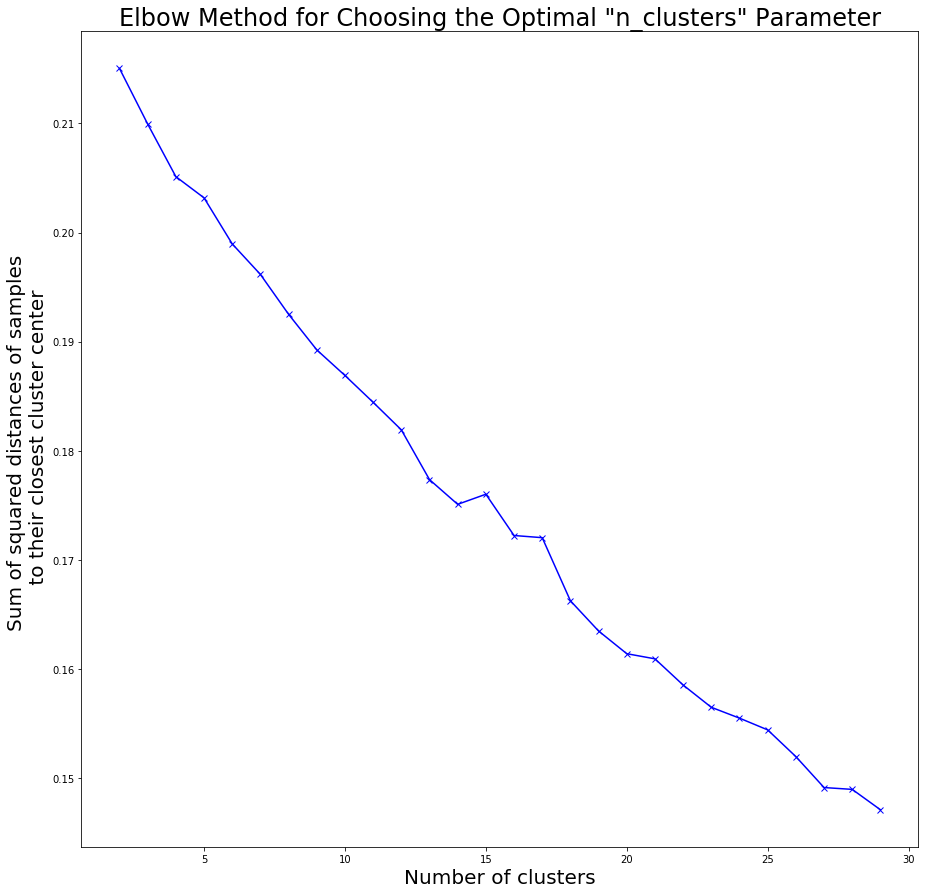

29


In [13]:
### Choosing the best parametrs for the KMeans clustring (TF-IDF).

n_clusters = [i for i in range(2, FLAGS["max_n_center"])]
distances = []
metric1 = []
metric2 = []
metric3 = []

for x in n_clusters:
    
    kmeans = KMeans(n_clusters=x, init="k-means++", n_init=3, max_iter=500)
    kmeans.fit(X_tfidf)
    distances.append(kmeans.inertia_)
    
    labels = kmeans.predict(X_tfidf)
    metric1 += [metrics.davies_bouldin_score(X_tfidf, labels)]
    metric2 += [metrics.calinski_harabasz_score(X_tfidf, labels)]
    metric3 += [metrics.silhouette_score(X_tfidf, labels, metric='euclidean')]

    
plt.figure(figsize=(15, 15))
plt.plot(n_clusters, distances, 'bx-')
plt.xlabel('Number of clusters', fontsize=20)
plt.ylabel('Sum of squared distances of samples \n to their closest cluster center', fontsize=20)
plt.title('Elbow Method for Choosing the Optimal \"n_clusters\" Parameter', fontsize=24)
plt.show()


print(np.argmin(metric1) + 2)
# print(np.argmax(metric2) + 2)
# print(np.argmax(metric3) + 2)

In [14]:
### KMeans Clustring (TF-IDF).

kmeans = KMeans(n_clusters=15, init="k-means++", n_init=10, max_iter=1000)
kmeans.fit(X_tfidf)
y_kmeans_tfidf = kmeans.predict(X_tfidf)

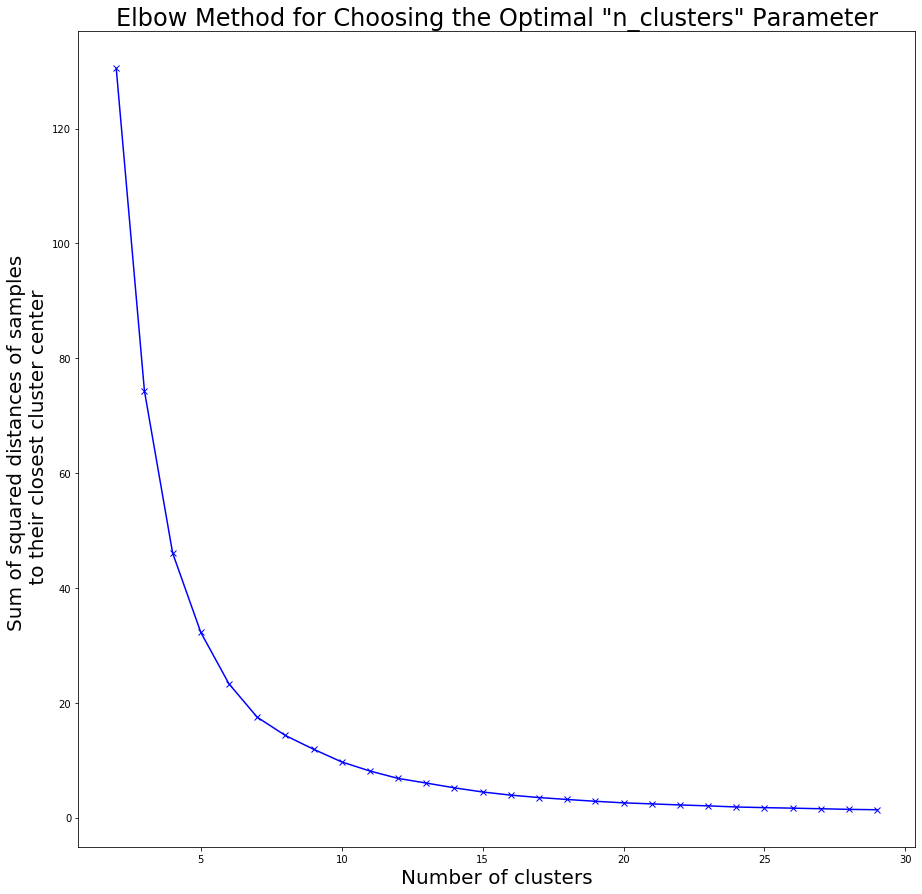

14


In [15]:
### Choosing the best parametrs for the KMeans clustring (W2V).

n_clusters = [i for i in range(2, FLAGS["max_n_center"])]
distances = []
metric1 = []
metric2 = []
metric3 = []

for x in n_clusters:
    kmeans = KMeans(n_clusters=x, init="k-means++", n_init=10, max_iter=1000)
    kmeans.fit(X_w2v)
    distances.append(kmeans.inertia_)
    
    labels = kmeans.predict(X_w2v)
    metric1 += [metrics.davies_bouldin_score(X_w2v, labels)]
    metric2 += [metrics.calinski_harabasz_score(X_w2v, labels)]
    metric3 += [metrics.silhouette_score(X_w2v, labels, metric='euclidean')]


plt.figure(figsize=(15, 15))
plt.plot(n_clusters, distances, 'bx-')
plt.xlabel('Number of clusters', fontsize=20)
plt.ylabel('Sum of squared distances of samples \n to their closest cluster center', fontsize=20)
plt.title('Elbow Method for Choosing the Optimal \"n_clusters\" Parameter', fontsize=24)
plt.show()


print(np.argmin(metric1) + 2)
# print(np.argmax(metric2) + 2)
# print(np.argmax(metric3) + 2)

In [16]:
### KMeans Clustring (W2V).

kmeans = KMeans(n_clusters=15, init="k-means++", n_init=10, max_iter=1000)
kmeans.fit(X_w2v)
y_kmeans_w2v = kmeans.predict(X_w2v)

yes
yes
yes
yes
yes


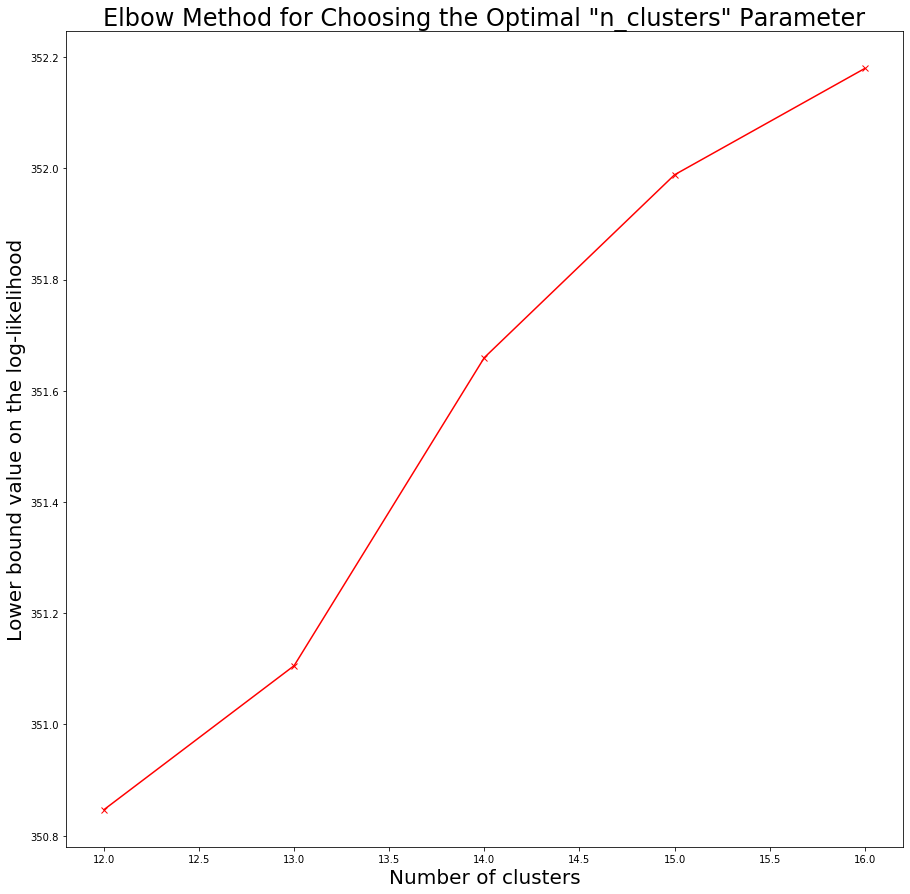

5


In [18]:
### Choosing the best parametrs for the GMM clustring (TF-IDF).

# n_clusters = [i for i in range(2, FLAGS["max_n_center"])]
n_clusters = [12, 13, 14, 15, 16]
lower_bounds = []
metric1 = []
metric2 = []
metric3 = []

for x in n_clusters:
    
    gmm = GaussianMixture(n_components=x, max_iter=50, n_init=1)
    gmm.fit(X_tfidf)
    lower_bounds.append(gmm.lower_bound_)
    
    labels = gmm.predict(X_tfidf)
    metric1 += [metrics.davies_bouldin_score(X_tfidf, labels)]
    metric2 += [metrics.calinski_harabasz_score(X_tfidf, labels)]
    metric3 += [metrics.silhouette_score(X_tfidf, labels, metric='euclidean')]

    
plt.figure(figsize=(15, 15))
plt.plot(n_clusters, lower_bounds, 'rx-')
plt.xlabel('Number of clusters', fontsize=20)
plt.ylabel('Lower bound value on the log-likelihood', fontsize=20)
plt.title('Elbow Method for Choosing the Optimal \"n_clusters\" Parameter', fontsize=24)
plt.show()


print(np.argmin(metric1) + 2)
# print(np.argmax(metric2) + 2)
# print(np.argmax(metric3) + 2)

In [19]:
### GMM Clustring (TF-IDF).

gmm = GaussianMixture(n_components=15, max_iter=500, n_init=2)
gmm.fit(X_tfidf)
y_gmm_tfidf = gmm.predict(X_tfidf)

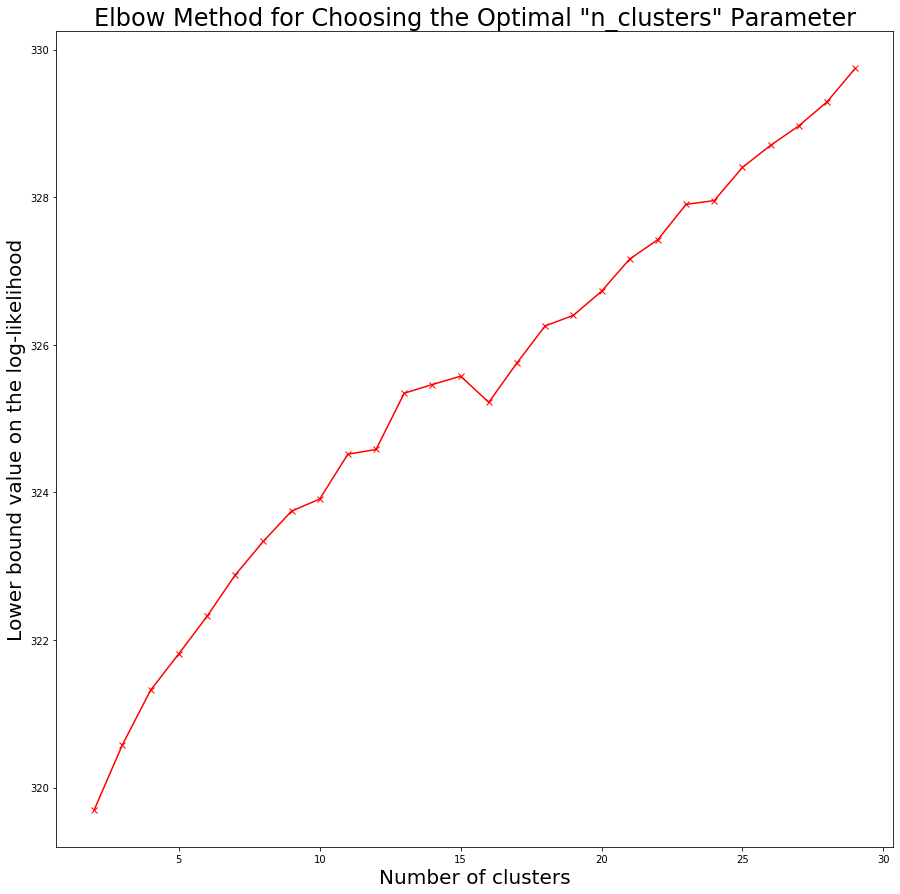

16


In [20]:
### Choosing the best parametrs for the GMM clustring (W2V).

n_clusters = [i for i in range(2, FLAGS["max_n_center"])]
lower_bounds = []
metric1 = []
metric2 = []
metric3 = []

for x in n_clusters:
    
    gmm = GaussianMixture(n_components=x, max_iter=500, n_init=2)
    gmm.fit(X_w2v)
    lower_bounds.append(gmm.lower_bound_)
    
    labels = gmm.predict(X_w2v)
    metric1 += [metrics.davies_bouldin_score(X_w2v, labels)]
    metric2 += [metrics.calinski_harabasz_score(X_w2v, labels)]
    metric3 += [metrics.silhouette_score(X_w2v, labels, metric='euclidean')]


plt.figure(figsize=(15, 15))
plt.plot(n_clusters, lower_bounds, 'rx-')
plt.xlabel('Number of clusters', fontsize=20)
plt.ylabel('Lower bound value on the log-likelihood', fontsize=20)
plt.title('Elbow Method for Choosing the Optimal \"n_clusters\" Parameter', fontsize=24)
plt.show()


print(np.argmin(metric1) + 2)
# print(np.argmax(metric2) + 2)
# print(np.argmax(metric3) + 2)

In [21]:
### GMM Clustring (W2V).

gmm = GaussianMixture(n_components=16, max_iter=500, n_init=2)
gmm.fit(X_w2v)
y_gmm_w2v = gmm.predict(X_w2v)

In [23]:
### Choosing the best parametrs for the ‬‬‫‪Hierarchical clustring (TF-IDF).

n_clusters = [i for i in range(2, FLAGS["max_n_center"])]
metric1 = []
metric2 = []
metric3 = []

for x in n_clusters:
    
    h = AgglomerativeClustering(n_clusters=x)
    labels = h.fit_predict(X_tfidf)
    
    metric1 += [metrics.davies_bouldin_score(X_tfidf, labels)]
    metric2 += [metrics.calinski_harabasz_score(X_tfidf, labels)]
    metric3 += [metrics.silhouette_score(X_tfidf, labels, metric='euclidean')]


print(np.argmin(metric1) + 2)
# print(np.argmax(metric2) + 2)
# print(np.argmax(metric3) + 2)

2


In [25]:
### ‬‬‫‪Hierarchical Clustring (TF-IDF).

h = AgglomerativeClustering(n_clusters=15)
y_hierarchical_tfidf = h.fit_predict(X_tfidf)

In [26]:
### Choosing the best parametrs for the ‬‬‫‪Hierarchical clustring (W2V).

n_clusters = [i for i in range(2, FLAGS["max_n_center"])]
metric1 = []
metric2 = []
metric3 = []

for x in n_clusters:
    
    h = AgglomerativeClustering(n_clusters=x)
    labels = h.fit_predict(X_w2v)
    
    metric1 += [metrics.davies_bouldin_score(X_w2v, labels)]
    metric2 += [metrics.calinski_harabasz_score(X_w2v, labels)]
    metric3 += [metrics.silhouette_score(X_w2v, labels, metric='euclidean')]


print(np.argmin(metric1) + 2)
# print(np.argmax(metric2) + 2)
# print(np.argmax(metric3) + 2)

14


In [27]:
### ‬‬‫‪Hierarchical Clustring (W2V).

h = AgglomerativeClustering(n_clusters=14)
y_hierarchical_w2v = h.fit_predict(X_w2v)

In [28]:
### Evaluations.

labels_true = data["major_label_number"]

names = ["Kmeans_(TF-IDF)", "Kmeans_(W2V)", "GMM_(TF-IDF)", "GMM_(W2V)",
         "Hierarchical_(TF-IDF)", " Hierarchical_(W2V)"]
predictions = [y_kmeans_tfidf, y_kmeans_w2v, y_gmm_tfidf, y_gmm_w2v, y_hierarchical_tfidf, y_hierarchical_w2v]

for name, labels_pred in zip(names, predictions):
    
    print(name + ": ")
    
    m1 = metrics.rand_score(labels_true, labels_pred)
    m2 = metrics.adjusted_rand_score(labels_true, labels_pred)
    print(m1, m2)

    m3 = metrics.mutual_info_score(labels_true, labels_pred)
    m4 = metrics.adjusted_mutual_info_score(labels_true, labels_pred)
    m5 = metrics.normalized_mutual_info_score(labels_true, labels_pred)
    print(m3, m4, m5)

    m6 = metrics.homogeneity_score(labels_true, labels_pred)
    m7 = metrics.completeness_score(labels_true, labels_pred)
    m8 = metrics.homogeneity_completeness_v_measure(labels_true, labels_pred)
    print(m6, m7, m8)

    m9 = metrics.fowlkes_mallows_score(labels_true, labels_pred)
    print(m9)
    
    print("\n")

Kmeans_(TF-IDF): 
0.7447300621767938 0.019700355226008836
0.2360337494485115 0.09070652663353614 0.10829558689690717
0.1071045462483263 0.10951341502303472 (0.1071045462483263, 0.10951341502303472, 0.10829558689690716)
0.16923839719884617


Kmeans_(W2V): 
0.7906294075909203 0.006984748026109411
0.07421785873239439 0.01510675323402428 0.03234389248702571
0.03367768423637865 0.03111172458417195 (0.03367768423637865, 0.03111172458417195, 0.03234389248702571)
0.12451339445650625


GMM_(TF-IDF): 
0.7816758008545032 0.05778506886546935
0.3975483802387172 0.1563928943263817 0.1721026822591526
0.18039470616685327 0.1645394606414562 (0.18039470616685327, 0.1645394606414562, 0.1721026822591526)
0.18378795413686655


GMM_(W2V): 
0.799315028676526 0.009343637439220762
0.08098899433698309 0.0163872080924905 0.03451527997233861
0.036750208433489535 0.03253659815410502 (0.036750208433489535, 0.03253659815410502, 0.0345152799723386)
0.12006825359153599


Hierarchical_(TF-IDF): 
0.547700827416004 -0.00

In [29]:
### Saving.

links = data["link"]

for name, labels_pred in zip(names, predictions):
    df = pd.DataFrame(np.array([links, labels_pred]).T, columns=["Link", "Prediction"])
    df.to_csv(path_or_buf=result_path + name + ".csv", index=False)

In [30]:
df

,Link,Prediction
0,https://www.hamshahrionline.ir/news/503910/پرت...,3
1,https://www.hamshahrionline.ir/news/503441/نخس...,12
2,https://www.hamshahrionline.ir/news/503002/ممن...,5
3,https://www.hamshahrionline.ir/news/502442/نکا...,9
4,https://www.hamshahrionline.ir/news/499583/چطو...,5
5,https://www.hamshahrionline.ir/news/499530/ممن...,9
6,https://www.hamshahrionline.ir/news/498104/مرد...,8
7,https://www.hamshahrionline.ir/news/497814/پیش...,8
8,https://www.hamshahrionline.ir/news/496981/وضع...,8
9,https://www.hamshahrionline.ir/news/496976/کاه...,9
